/tmp/ipykernel_207211/3459045410.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dados_grafos = torch.load(PATH_GRAFOS)
/home/grad/si/24/pedrobacelar.rigueira/miniconda

Total de amostras no dataset: 1600
Número de amostras de treino: 1120
Número de amostras de validação: 240
Número de amostras de teste: 240


Treinamento: 100%|██████████| 50/50 [01:26<00:00,  1.74s/it]


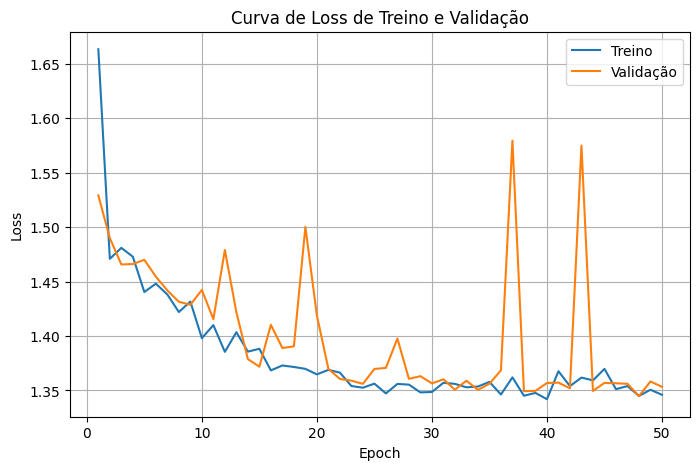

Loss no teste: 1.3538

F1 Score por classe:
1dAVb: 0.0000
RBBB: 0.0000
LBBB: 0.0000
SB: 0.0000
ST: 0.0000
AF: 0.0000
normal: 0.7629

F1 Macro: 0.1090

Exemplos do conjunto de teste:
Exemplo 1:
  Rótulo verdadeiro:  6
  Predição (classe):  6
  Probabilidades:  [0.06894463 0.06309073 0.05896809 0.06791788 0.06936892 0.06463034
 0.6070794 ]
Exemplo 2:
  Rótulo verdadeiro:  5
  Predição (classe):  6
  Probabilidades:  [0.07783324 0.06381111 0.05475485 0.07056776 0.06668983 0.05804306
 0.6083002 ]
Exemplo 3:
  Rótulo verdadeiro:  6
  Predição (classe):  6
  Probabilidades:  [0.0717722  0.06385138 0.05745075 0.06881605 0.0676578  0.06206918
 0.6083827 ]
Exemplo 4:
  Rótulo verdadeiro:  4
  Predição (classe):  6
  Probabilidades:  [0.07488949 0.06384225 0.05613908 0.06957635 0.06485763 0.05957516
 0.61112005]
Exemplo 5:
  Rótulo verdadeiro:  6
  Predição (classe):  6
  Probabilidades:  [0.05665068 0.05591177 0.06224883 0.06222732 0.07012093 0.06993911
 0.6229014 ]


In [9]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, GINConv

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm

# =============================================================================
# 1. Carregar os grafos salvos e o CSV com as labels
# =============================================================================

# Paths para os arquivos
PATH_GRAFOS = "/scratch/pedro.bacelar/Clustering-Paper/Grafo/dataset/ecg_visibility_graphs_by_id.pt"
PATH_EXAMS = "/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams.csv"

# Carrega os grafos (o arquivo deve conter um dicionário com a chave 'grafos')
dados_grafos = torch.load(PATH_GRAFOS)
grafos_dict = dados_grafos["grafos"]

# Carrega o CSV com as informações dos exames (incluindo as colunas de classe)
exams_df = pd.read_csv(PATH_EXAMS)

# =============================================================================
# 2. Criar os rótulos a partir do CSV
# =============================================================================
def get_label(row):
    """
    Para cada linha do CSV, retorna um inteiro que representa o rótulo exclusivo.
    Ordem das classes: ["1dAVb", "RBBB", "LBBB", "SB", "ST", "AF"].
    Se exatamente uma dessas colunas for True, retorna o índice correspondente (0 a 5).
    Se nenhuma for True (exame sem doença), retorna 6, que corresponde à classe "normal".
    """
    classes = ["1dAVb", "RBBB", "LBBB", "SB", "ST", "AF"]
    values = row[classes].values.astype(bool)
    if values.sum() == 1:
        return int(np.argmax(values))
    else:
        return 6  # Rótulo para "normal" (sem doença)

# Aplica a função e cria uma nova coluna com os rótulos (inteiros)
exams_df["label_idx"] = exams_df.apply(get_label, axis=1)

# =============================================================================
# 3. Construir o dataset do PyTorch Geometric (usando apenas a lead 0)
# =============================================================================
dataset = []
chaves_grafos = list(grafos_dict.keys())

for exam_id in chaves_grafos:
    # Seleciona as linhas do CSV que têm o mesmo exam_id (convertendo para inteiro)
    exam_rows = exams_df[exams_df["exam_id"] == int(exam_id)]
    if exam_rows.empty:
        print(f"Exame {exam_id} não encontrado no CSV. Ignorando.")
        continue

    exam_info = exam_rows.iloc[0]
    label = get_label(exam_info)  # rótulo inteiro (0 a 6)
    
    try:
        grafo_lead0 = grafos_dict[exam_id]["lead_0"]
    except KeyError:
        print(f"Lead_0 não encontrado para o exam_id {exam_id}. Ignorando.")
        continue

    # Cria o objeto Data com os dados do grafo:
    # - x: features dos nós (forma: [num_nodes, 3])
    # - edge_index: conectividade (forma: [2, num_edges])
    # - y: rótulo exclusivo, armazenado como um inteiro (forma: []).
    data = Data(
        x = grafo_lead0["node_features"],
        edge_index = grafo_lead0["edge_index"],
        y = torch.tensor(label, dtype=torch.long)  # sem unsqueeze, pois é um escalar
    )
    data.exam_id = exam_id  # opcional, para referência
    dataset.append(data)

print(f"Total de amostras no dataset: {len(dataset)}")

# =============================================================================
# 4. Dividir o dataset em treino, validação e teste
# =============================================================================
# 70% para treino e 30% para (validação + teste), depois divide igualmente
train_data, temp_data = train_test_split(dataset, test_size=0.30, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.50, random_state=42)

print(f"Número de amostras de treino: {len(train_data)}")
print(f"Número de amostras de validação: {len(val_data)}")
print(f"Número de amostras de teste: {len(test_data)}")

# Cria os DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# =============================================================================
# 5. Definir o modelo – nova arquitetura baseada em GIN para classificação exclusiva
# =============================================================================
class GINExclusive(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.2):
        """
        num_features: número de features de entrada por nó (3)
        hidden_channels: tamanho do embedding intermediário
        num_classes: número de classes exclusivas (neste exemplo, 7: 6 doenças + 1 normal)
        dropout: taxa de dropout
        """
        super(GINExclusive, self).__init__()
        # Primeira camada GIN
        self.mlp1 = nn.Sequential(
            nn.Linear(num_features, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv1 = GINConv(self.mlp1)

        # Segunda camada GIN
        self.mlp2 = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv2 = GINConv(self.mlp2)

        # Terceira camada GIN
        self.mlp3 = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv3 = GINConv(self.mlp3)

        # Camadas finais para converter o embedding global em logits
        self.lin1 = nn.Linear(hidden_channels, hidden_channels * 2)
        self.bn = nn.BatchNorm1d(hidden_channels * 2)
        self.lin2 = nn.Linear(hidden_channels * 2, num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)

        # Agrega os embeddings dos nós de cada grafo em um único vetor
        x = global_mean_pool(x, batch)

        # Camadas finais fully-connected com batch norm e dropout
        x = self.lin1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        out = self.lin2(x)  # Saída: logits com formato [num_graphs, num_classes]
        return out

# Como agora temos 7 classes (índices 0-5 para doenças e 6 para normal)
num_classes = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GINExclusive(num_features=3, hidden_channels=64, num_classes=num_classes, dropout=0.2).to(device)

# =============================================================================
# 6. Preparar o treinamento
# =============================================================================
# Para classificação exclusiva usamos CrossEntropyLoss (que aplica softmax internamente)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# =============================================================================
# 7. Funções de treinamento e avaliação
# =============================================================================
def train_epoch(loader):
    model.train()
    epoch_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)  # Saída: logits, formato [num_graphs, num_classes]
        # CrossEntropyLoss espera: out com shape [N, num_classes] e targets com shape [N]
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        # Multiplica pela quantidade de exemplos no batch
        epoch_loss += loss.item() * data.num_graphs
    return epoch_loss / len(loader.dataset)

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_logits = []
    all_targets = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)  # logits
            loss = criterion(out, data.y)
            total_loss += loss.item() * data.num_graphs
            all_logits.append(out.cpu())
            all_targets.append(data.y.cpu())
    avg_loss = total_loss / len(loader.dataset)
    all_logits = torch.cat(all_logits, dim=0)  # [N, num_classes]
    all_targets = torch.cat(all_targets, dim=0)  # [N]
    return avg_loss, all_logits, all_targets

# =============================================================================
# 8. Treinar o modelo e plotar as curvas de loss
# =============================================================================
num_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(1, num_epochs+1), desc="Treinamento"):
    train_loss = train_epoch(train_loader)
    val_loss, _, _ = evaluate(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Treino")
plt.plot(range(1, num_epochs+1), val_losses, label="Validação")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curva de Loss de Treino e Validação")
plt.legend()
plt.grid(True)
plt.show()

# =============================================================================
# 9. Avaliação no conjunto de teste e cálculo do F1 Score
# =============================================================================
test_loss, test_logits, test_targets = evaluate(test_loader)
print(f"Loss no teste: {test_loss:.4f}")

# Para inferência, aplicamos softmax e usamos argmax para obter a classe prevista
test_probs = F.softmax(test_logits, dim=1)  # Probabilidades, formato: [N, num_classes]
test_preds = test_probs.argmax(dim=1)         # Predição como índice, formato: [N]

# Converte para numpy para calcular métricas
test_preds_np = test_preds.numpy()
test_targets_np = test_targets.numpy()

# Calcula o F1 Score para cada classe
classes_list = ["1dAVb", "RBBB", "LBBB", "SB", "ST", "AF", "normal"]
f1_per_class = {}
for i, cls in enumerate(classes_list):
    f1 = f1_score(test_targets_np == i, test_preds_np == i, zero_division=1)
    f1_per_class[cls] = f1

print("\nF1 Score por classe:")
for cls in classes_list:
    print(f"{cls}: {f1_per_class[cls]:.4f}")

# Calcula o F1 Macro (média dos F1s)
f1_macro = f1_score(test_targets_np, test_preds_np, average='macro', zero_division=1)
print(f"\nF1 Macro: {f1_macro:.4f}")

# Exibe 5 exemplos do conjunto de teste com seus rótulos verdadeiros e predições
num_examples = 5
print("\nExemplos do conjunto de teste:")
for i in range(num_examples):
    print(f"Exemplo {i+1}:")
    print("  Rótulo verdadeiro: ", test_targets_np[i])
    print("  Predição (classe): ", test_preds_np[i])
    # Opcional: Mostra as probabilidades para cada classe
    print("  Probabilidades: ", test_probs[i].detach().numpy())


/tmp/ipykernel_241824/1889897426.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dados_grafos = torch.load(PATH_GRAFOS)
/home/grad/si/24/guilherme.evangelista/anaconda3

Total de amostras no dataset: 2500
Número de amostras de treino: 1750
Número de amostras de validação: 375
Número de amostras de teste: 375


Treinamento: 100%|██████████| 10/10 [00:33<00:00,  3.40s/it]


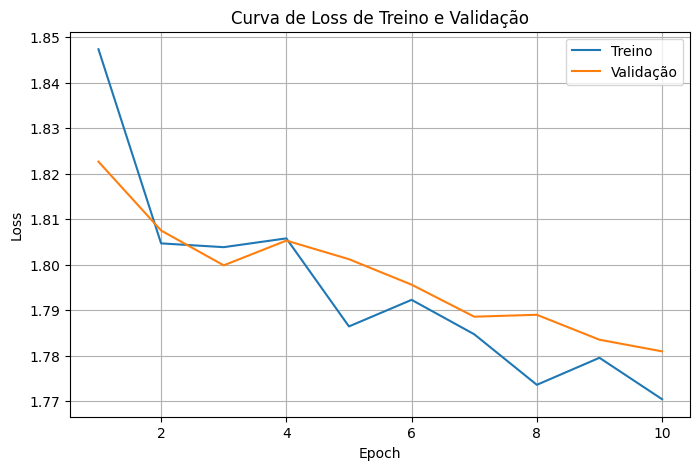

Loss no teste: 1.7646

F1 Score por classe:
1dAVb: 0.0000
RBBB: 0.0000
LBBB: 0.0000
SB: 0.0000
ST: 0.0000
AF: 0.0000
normal: 0.5741

F1 Macro: 0.0820

Exemplos do conjunto de teste:
Exemplo 1:
  Rótulo verdadeiro:  3
  Predição (classe):  6
  Probabilidades:  [0.11633787 0.09720705 0.1036389  0.10351859 0.11907873 0.12274174
 0.3374771 ]
Exemplo 2:
  Rótulo verdadeiro:  6
  Predição (classe):  6
  Probabilidades:  [0.11861704 0.12280855 0.11994915 0.1227056  0.10162668 0.1102937
 0.3039993 ]
Exemplo 3:
  Rótulo verdadeiro:  3
  Predição (classe):  6
  Probabilidades:  [0.09284814 0.10236737 0.10732356 0.09228607 0.11047461 0.1026634
 0.39203697]
Exemplo 4:
  Rótulo verdadeiro:  0
  Predição (classe):  6
  Probabilidades:  [0.10637953 0.07761603 0.08445654 0.07443798 0.12781498 0.13105313
 0.39824182]
Exemplo 5:
  Rótulo verdadeiro:  2
  Predição (classe):  6
  Probabilidades:  [0.0916752  0.10159911 0.10681468 0.09117299 0.11047459 0.10222919
 0.3960342 ]


In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, GINConv

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm

# =============================================================================
# 1. Carregar os grafos salvos e o CSV com as labels
# =============================================================================

# Paths para os arquivos
# Alteramos o nome do arquivo para o salvo pelo script PyG.
PATH_GRAFOS = "../dataset/ecg_visibility_graphs_by_id_pyg.pt"
PATH_EXAMS = "/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams.csv"

# Carrega os grafos (o arquivo deve conter um dicionário com a chave 'grafos')
dados_grafos = torch.load(PATH_GRAFOS)
grafos_dict = dados_grafos["grafos"]

# Carrega o CSV com as informações dos exames (incluindo as colunas de classe)
exams_df = pd.read_csv(PATH_EXAMS)

# =============================================================================
# 2. Criar os rótulos a partir do CSV
# =============================================================================
def get_label(row):
    """
    Para cada linha do CSV, retorna um inteiro que representa o rótulo exclusivo.
    Ordem das classes: ["1dAVb", "RBBB", "LBBB", "SB", "ST", "AF"].
    Se exatamente uma dessas colunas for True, retorna o índice correspondente (0 a 5).
    Se nenhuma for True (exame sem doença), retorna 6, que corresponde à classe "normal".
    """
    classes = ["1dAVb", "RBBB", "LBBB", "SB", "ST", "AF"]
    values = row[classes].values.astype(bool)
    if values.sum() == 1:
        return int(np.argmax(values))
    else:
        return 6  # Rótulo para "normal" (sem doença)

# Aplica a função e cria uma nova coluna com os rótulos (inteiros)
exams_df["label_idx"] = exams_df.apply(get_label, axis=1)

# =============================================================================
# 3. Construir o dataset do PyTorch Geometric (usando apenas a lead 0)
# =============================================================================
dataset = []
chaves_grafos = list(grafos_dict.keys())

for exam_id in chaves_grafos:
    # Seleciona as linhas do CSV que têm o mesmo exam_id (convertendo para inteiro)
    exam_rows = exams_df[exams_df["exam_id"] == int(exam_id)]
    if exam_rows.empty:
        print(f"Exame {exam_id} não encontrado no CSV. Ignorando.")
        continue

    exam_info = exam_rows.iloc[0]
    label = get_label(exam_info)  # rótulo inteiro (0 a 6)
    
    try:
        # Aqui, agora os grafos são objetos Data do PyG.
        grafo_lead0 = grafos_dict[exam_id]["lead_0"]
    except KeyError:
        print(f"Lead_0 não encontrado para o exam_id {exam_id}. Ignorando.")
        continue

    # Cria o objeto Data com os dados do grafo:
    # - x: features dos nós (forma: [num_nodes, 3])
    # - edge_index: conectividade (forma: [2, num_edges])
    # - y: rótulo exclusivo, armazenado como um inteiro (forma: []).
    data = Data(
        x = grafo_lead0.x,                 # Acessa as features diretamente
        edge_index = grafo_lead0.edge_index,  # Acessa as arestas diretamente
        y = torch.tensor(label, dtype=torch.long)
    )
    data.exam_id = exam_id  # opcional, para referência
    dataset.append(data)

print(f"Total de amostras no dataset: {len(dataset)}")

# =============================================================================
# 4. Dividir o dataset em treino, validação e teste
# =============================================================================
# 70% para treino e 30% para (validação + teste), depois divide igualmente
train_data, temp_data = train_test_split(dataset, test_size=0.30, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.50, random_state=42)

print(f"Número de amostras de treino: {len(train_data)}")
print(f"Número de amostras de validação: {len(val_data)}")
print(f"Número de amostras de teste: {len(test_data)}")

# Cria os DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# =============================================================================
# 5. Definir o modelo – nova arquitetura baseada em GIN para classificação exclusiva
# =============================================================================
class GINExclusive(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.2):
        """
        num_features: número de features de entrada por nó (3)
        hidden_channels: tamanho do embedding intermediário
        num_classes: número de classes exclusivas (neste exemplo, 7: 6 doenças + 1 normal)
        dropout: taxa de dropout
        """
        super(GINExclusive, self).__init__()
        # Primeira camada GIN
        self.mlp1 = nn.Sequential(
            nn.Linear(num_features, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv1 = GINConv(self.mlp1)

        # Segunda camada GIN
        self.mlp2 = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv2 = GINConv(self.mlp2)

        # Terceira camada GIN
        self.mlp3 = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv3 = GINConv(self.mlp3)

        # Camadas finais para converter o embedding global em logits
        self.lin1 = nn.Linear(hidden_channels, hidden_channels * 2)
        self.bn = nn.BatchNorm1d(hidden_channels * 2)
        self.lin2 = nn.Linear(hidden_channels * 2, num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)

        # Agrega os embeddings dos nós de cada grafo em um único vetor
        x = global_mean_pool(x, batch)

        # Camadas finais fully-connected com batch norm e dropout
        x = self.lin1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        out = self.lin2(x)  # Saída: logits com formato [num_graphs, num_classes]
        return out

# Como agora temos 7 classes (índices 0-5 para doenças e 6 para normal)
num_classes = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GINExclusive(num_features=3, hidden_channels=64, num_classes=num_classes, dropout=0.2).to(device)

# =============================================================================
# 6. Preparar o treinamento
# =============================================================================
# Para classificação exclusiva usamos CrossEntropyLoss (que aplica softmax internamente)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# =============================================================================
# 7. Funções de treinamento e avaliação
# =============================================================================
def train_epoch(loader):
    model.train()
    epoch_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)  # Saída: logits, formato [num_graphs, num_classes]
        # CrossEntropyLoss espera: out com shape [N, num_classes] e targets com shape [N]
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        # Multiplica pela quantidade de exemplos no batch
        epoch_loss += loss.item() * data.num_graphs
    return epoch_loss / len(loader.dataset)

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_logits = []
    all_targets = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)  # logits
            loss = criterion(out, data.y)
            total_loss += loss.item() * data.num_graphs
            all_logits.append(out.cpu())
            all_targets.append(data.y.cpu())
    avg_loss = total_loss / len(loader.dataset)
    all_logits = torch.cat(all_logits, dim=0)  # [N, num_classes]
    all_targets = torch.cat(all_targets, dim=0)  # [N]
    return avg_loss, all_logits, all_targets

# =============================================================================
# 8. Treinar o modelo e plotar as curvas de loss
# =============================================================================
num_epochs = 10
train_losses = []
val_losses = []

for epoch in tqdm(range(1, num_epochs+1), desc="Treinamento"):
    train_loss = train_epoch(train_loader)
    val_loss, _, _ = evaluate(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Treino")
plt.plot(range(1, num_epochs+1), val_losses, label="Validação")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curva de Loss de Treino e Validação")
plt.legend()
plt.grid(True)
plt.show()

# =============================================================================
# 9. Avaliação no conjunto de teste e cálculo do F1 Score
# =============================================================================
test_loss, test_logits, test_targets = evaluate(test_loader)
print(f"Loss no teste: {test_loss:.4f}")

# Para inferência, aplicamos softmax e usamos argmax para obter a classe prevista
test_probs = F.softmax(test_logits, dim=1)  # Probabilidades, formato: [N, num_classes]
test_preds = test_probs.argmax(dim=1)         # Predição como índice, formato: [N]

# Converte para numpy para calcular métricas
test_preds_np = test_preds.numpy()
test_targets_np = test_targets.numpy()

# Calcula o F1 Score para cada classe
classes_list = ["1dAVb", "RBBB", "LBBB", "SB", "ST", "AF", "normal"]
f1_per_class = {}
for i, cls in enumerate(classes_list):
    f1 = f1_score(test_targets_np == i, test_preds_np == i, zero_division=1)
    f1_per_class[cls] = f1

print("\nF1 Score por classe:")
for cls in classes_list:
    print(f"{cls}: {f1_per_class[cls]:.4f}")

# Calcula o F1 Macro (média dos F1s)
f1_macro = f1_score(test_targets_np, test_preds_np, average='macro', zero_division=1)
print(f"\nF1 Macro: {f1_macro:.4f}")

# Exibe 5 exemplos do conjunto de teste com seus rótulos verdadeiros e predições
num_examples = 5
print("\nExemplos do conjunto de teste:")
for i in range(num_examples):
    print(f"Exemplo {i+1}:")
    print("  Rótulo verdadeiro: ", test_targets_np[i])
    print("  Predição (classe): ", test_preds_np[i])
    # Opcional: Mostra as probabilidades para cada classe
    print("  Probabilidades: ", test_probs[i].detach().numpy())


In [13]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, GINConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm

##############################################
# Função para extrair subgrafo (nós 1000 a 2000)
##############################################
def extract_subgraph(data, start=1000, end=2000):
    num_nodes = data.x.shape[0]
    if num_nodes < end:
        return data  # Retorna o grafo completo se não houver nós suficientes

    node_indices = torch.arange(start, end)
    new_x = data.x[node_indices]
    
    edge_index = data.edge_index
    mask = (edge_index[0] >= start) & (edge_index[0] < end) & (edge_index[1] >= start) & (edge_index[1] < end)
    new_edge_index = edge_index[:, mask] - start
    
    new_data = Data(x=new_x, edge_index=new_edge_index)
    if hasattr(data, "y"):
        new_data.y = data.y
    if hasattr(data, "exam_id"):
        new_data.exam_id = data.exam_id
    return new_data

##############################################
# Pré-processamento do dataset
##############################################
def preprocess_dataset(PATH_GRAFOS, PATH_EXAMS, save_path="preprocessed_dataset.pt"):
    # Carregar grafos e CSV
    dados_grafos = torch.load(PATH_GRAFOS)
    grafos_dict = dados_grafos["grafos"]
    exams_df = pd.read_csv(PATH_EXAMS)

    # Função para criar rótulo (exclusivo)
    def get_label(row):
        classes = ["1dAVb", "RBBB", "LBBB", "SB", "ST", "AF"]
        values = row[classes].values.astype(bool)
        return int(np.argmax(values)) if values.sum() == 1 else 6

    exams_df["label_idx"] = exams_df.apply(get_label, axis=1)
    
    dataset = []
    chaves_grafos = list(grafos_dict.keys())
    for exam_id in chaves_grafos:
        exam_rows = exams_df[exams_df["exam_id"] == int(exam_id)]
        if exam_rows.empty:
            continue
        exam_info = exam_rows.iloc[0]
        label = get_label(exam_info)
        try:
            grafo_lead0 = grafos_dict[exam_id]["lead_0"]
        except KeyError:
            continue
        data = Data(
            x = grafo_lead0["node_features"],
            edge_index = grafo_lead0["edge_index"],
            y = torch.tensor(label, dtype=torch.long)
        )
        data.exam_id = exam_id
        # Extrai somente nós de 1000 a 2000
        sub_data = extract_subgraph(data, start=1000, end=2000)
        if sub_data.x.shape[0] == data.x.shape[0]:
            print(f"Exame {exam_id}: grafo possui menos de 2000 nós. Usando grafo completo.")
        dataset.append(sub_data)
    print(f"Total de amostras pré-processadas: {len(dataset)}")
    torch.save(dataset, save_path)
    return dataset

##############################################
# Carregar ou pré-processar o dataset
##############################################
PREPROCESSED_PATH = "preprocessed_dataset.pt"
if os.path.exists(PREPROCESSED_PATH):
    print("Carregando dataset pré-processado...")
    dataset = torch.load(PREPROCESSED_PATH)
else:
    print("Pré-processando o dataset...")
    PATH_GRAFOS = "/scratch/pedro.bacelar/Clustering-Paper/Grafo/dataset/ecg_visibility_graphs_by_id.pt"
    PATH_EXAMS = "/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams.csv"
    dataset = preprocess_dataset(PATH_GRAFOS, PATH_EXAMS, save_path=PREPROCESSED_PATH)

##############################################
# Dividir o dataset em treino, validação e teste
##############################################
train_data, temp_data = train_test_split(dataset, test_size=0.30, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.50, random_state=42)

print(f"Número de amostras de treino: {len(train_data)}")
print(f"Número de amostras de validação: {len(val_data)}")
print(f"Número de amostras de teste: {len(test_data)}")

##############################################
# Criar DataLoaders com num_workers (para paralelismo)
##############################################
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

##############################################
# (Resto do código: definição do modelo, treinamento e avaliação)
##############################################

# Exemplo: modelo de classificação com GIN para classes exclusivas (7 classes)
class GINExclusive(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.2):
        super(GINExclusive, self).__init__()
        self.mlp1 = nn.Sequential(
            nn.Linear(num_features, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv1 = GINConv(self.mlp1)
        self.mlp2 = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv2 = GINConv(self.mlp2)
        self.mlp3 = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv3 = GINConv(self.mlp3)
        self.lin1 = nn.Linear(hidden_channels, hidden_channels * 2)
        self.bn = nn.BatchNorm1d(hidden_channels * 2)
        self.lin2 = nn.Linear(hidden_channels * 2, num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        out = self.lin2(x)
        return out

num_classes = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GINExclusive(num_features=3, hidden_channels=64, num_classes=num_classes, dropout=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_epoch(loader):
    model.train()
    epoch_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * data.num_graphs
    return epoch_loss / len(loader.dataset)

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_logits = []
    all_targets = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item() * data.num_graphs
            all_logits.append(out.cpu())
            all_targets.append(data.y.cpu())
    avg_loss = total_loss / len(loader.dataset)
    all_logits = torch.cat(all_logits, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    return avg_loss, all_logits, all_targets

num_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(1, num_epochs+1), desc="Treinamento"):
    train_loss = train_epoch(train_loader)
    val_loss, _, _ = evaluate(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Treino")
plt.plot(range(1, num_epochs+1), val_losses, label="Validação")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curva de Loss de Treino e Validação")
plt.legend()
plt.grid(True)
plt.show()

test_loss, test_logits, test_targets = evaluate(test_loader)
print(f"Loss no teste: {test_loss:.4f}")
test_probs = F.softmax(test_logits, dim=1)
test_preds = test_probs.argmax(dim=1)

test_preds_np = test_preds.numpy()
test_targets_np = test_targets.numpy()
classes_list = ["1dAVb", "RBBB", "LBBB", "SB", "ST", "AF", "normal"]
f1_per_class = {}
for i, cls in enumerate(classes_list):
    f1 = f1_score(test_targets_np == i, test_preds_np == i, zero_division=1)
    f1_per_class[cls] = f1

print("\nF1 Score por classe:")
for cls in classes_list:
    print(f"{cls}: {f1_per_class[cls]:.4f}")
f1_macro = f1_score(test_targets_np, test_preds_np, average='macro', zero_division=1)
print(f"\nF1 Macro: {f1_macro:.4f}")

num_examples = 5
print("\nExemplos do conjunto de teste:")
for i in range(num_examples):
    print(f"Exemplo {i+1}:")
    print("  Rótulo verdadeiro: ", test_targets_np[i])
    print("  Predição (classe): ", test_preds_np[i])
    print("  Probabilidades: ", test_probs[i].detach().numpy())


Carregando dataset pré-processado...


/tmp/ipykernel_207211/3412674304.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(PREPROCESSED_PATH)
/home/grad/si/24/pedrobacelar.rigueira/minicond

Número de amostras de treino: 1120
Número de amostras de validação: 240
Número de amostras de teste: 240


Treinamento:   4%|▍         | 2/50 [00:23<09:29, 11.87s/it]


KeyboardInterrupt: 